## LFP Preprocessing

These are magics that provide certain functionality. Specifically, if you edit functions that are called in this notebook, the functions are reloaded so the changes propagate here without needing to reload the notebook.


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 
import scipy

# I only want to see warnings once
warnings.filterwarnings('ignore')

Note: If you have installed the LFPAnalysis package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [3]:
import sys
sys.path.append('/hpc/users/tostag01/resources/LFPAnalysis_GT/')

In [4]:
from LFPAnalysis_GT import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, SNT_utils

## Pre-process (run 1x): 

In the pre-processing functions below, we: 

1. load the raw data (either a .edf file or a folder of .nlx files) into mne objects for use with the mne toolbox: https://mne.tools/stable/index.html.

2. load the localized electrode names from the .csv or .xlsx file listing their MNI coordinates into the mne object

3. filter and resample as necessary

4. re-reference 

In [5]:
subj_ids = ['MS030']
subj_sites = ['MSSM']
subj_formats = ['edf']
                
base_dir = '/sc/arion/projects/OlfMem/tostag01/SocialNav'

In [7]:
load_preproc_data = False
load_reref_data = False

In [8]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    # Check if path exists for saving, and if not, make it
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one, so grab it with the zero-index 
    elec_file = elec_files[0]
    
    ### Pre-process data
    if load_preproc_data:
        mne_data = mne.io.Raw(f'{save_path}raw_ieeg.fif', preload=True)
        
    else:
        # Make MNE file
        mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                 elec_path=elec_file,
                                                 format=format,
                                                 return_data=True,
                                                 site=site,
                                                 check_bad=False) # changed this to not annotate anything as bad 

        # Save this data so that you don't need this step again:
        mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)
        
    ### Bipolar re-reference data
    if load_reref_data:
        mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
    else:
        # Re-reference neural data
        mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                  elec_path=elec_file, 
                                                  method='bipolar', 
                                                  site=site)

        # Save this data so that you don't need this step again:
        mne_data_reref.save(f'{save_path}/ieeg_bp.fif', overwrite=True)

    # Should also save out re-referenced elec_file: 
    elec_data = lfp_preprocess_utils.load_elec(elec_file)
    anode_list = [x.split('-')[0] for x in mne_data_reref.ch_names]
    elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
    elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])

    # Add region to the data frame 

    manual_col = [col for col in elec_df.columns if 'manual' in col.lower()][0]
    all_regions = [] 
    for chan_name in elec_df.label.unique():
        elec_region = analysis_utils.select_rois_picks(elec_df, chan_name, manual_col=manual_col)
        all_regions.append(elec_region) 

    elec_df['SNT_region'] = all_regions
    elec_df['hemisphere'] = elec_df.label.apply(lambda x: x[0])

    elec_df.to_csv(f'{save_path}/labels_bp', index=False)


Working on subj MS030
Extracting EDF parameters from /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS030/raw/neural/MS030_SocialNav.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3067007  =      0.000 ...  2995.124 secs...
Writing /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS030/raw/neural/photodiode.fif
Closing /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS030/raw/neural/photodiode.fif
[done]
Number of electrodes in the mne file is greater than the number of electrodes in the localization file
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   30.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:   34.6s finished


Writing /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS030/raw/neural/lfp_data.fif
Closing /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS030/raw/neural/lfp_data.fif
[done]
Writing /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS030/LFP/raw_ieeg.fif
Closing /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS030/LFP/raw_ieeg.fif
[done]
Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=72, n_times=1497562
    Range : 0 ... 1497561 =      0.000 ...  2995.122 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas4-lacas5, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, lacas9-lacas10, lagit1-lagit2, lagit2-lagit3, lagit3-lagit4, lagit4-lagit5, lagit5-lagit6, lagit6-lagit7, lagit7-lagit8, lagit8-lagit9, lcmmf1-lcmmf2, lcmmf2-lcmmf3, lcmmf3-lcmmf4, lcmmf4-lcmmf5, lcmmf5-lc

 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

## NOW look at the data to manually remove channels: 

After bipolar referencing: 

In [10]:
%matplotlib notebook 

In [13]:
# Scroll up/down and left/right using your keyboard. CLICK on a channel to turn it 'grey' and mark as a 'bad' channel. 
# If you click a grey channel again it will unmark it. 

mne_data_reref = mne.io.read_raw_fif(f'{save_path}/ieeg_bp.fif', preload=True)
fig = mne_data_reref.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data_reref._data.max()/30
                     )

Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS038/LFP//ieeg_bp.fif...
    Range : 0 ... 1346218 =      0.000 ...  2692.436 secs
Ready.
Reading 0 ... 1346218  =      0.000 ...  2692.436 secs...
Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>

In [14]:
# ALSO look at the power spectra! 
# You can click on channels here to identify them, and go back to the viz above to mark them as noise if need be

mne_data_reref.compute_psd().plot()

Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data

Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 

First, you may need to MANUALLY clean the photodiode signal if the recording quality is poor. Load it, plot it, and try to isolate/amplify the pulses. 

Working on subj MS030
9 responses missed for MS030
There are 63 behav syncs detected
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/data/MS030/raw/neural/photodiode.fif...
Isotrak not found
    Range : 0 ... 3067007 =      0.000 ...  2995.124 secs
Ready.
Reading 0 ... 3067007  =      0.000 ...  2995.124 secs...
There are 66 neural syncs detected
Max rval with slope of 1.0137373699396954 and offset of 48.26914492235858


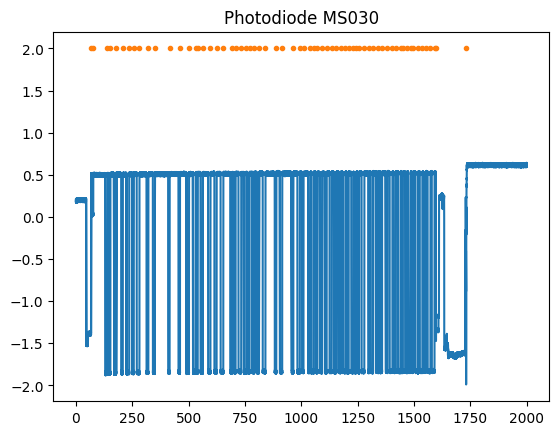

In [10]:
slopes = {f'{x}': [] for x in subj_ids}
offsets = {f'{x}': [] for x in subj_ids}

for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    print(f'Working on subj {subj_id}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'

    behav_path = f'{base_dir}/data/{subj_id}/raw/behav/'
    log_file = glob(f'{behav_path}/*.log')[0]
    time_df = SNT_utils.parse_logfile(log_file)
    time_df.to_csv(f'{base_dir}/preproc/{subj_id}/behav/time_df.csv', index=False)
    missing_responses = time_df[(time_df['decision_trial_start'].notna()) & (time_df['rt'] == 0)]
    print(f'{missing_responses.shape[0]} responses missed for {subj_id}')

    beh_ts = time_df['decision_trial_start'].values
    beh_ts = beh_ts[~np.isnan(beh_ts)]
    print(f'There are {len(beh_ts)} behav syncs detected')
    
    # Synchronize to the photodiode or whatever your neural sync signal is
    if subj_id == 'MS038':
        photodiode_data = mne.io.read_raw_fif(f'{save_path}clean_photodiode.fif', preload=True)
        photodiode_data._data = photodiode_data._data[:,600000:]
        
        smoothSize=35 
        windSize=20
        height=5.6       
        
    else:
        photodiode_data = mne.io.read_raw_fif(f'{load_path}photodiode.fif', preload=True)
        smoothSize=15
        windSize=15
        height=0.3

#     try:
#         slope, offset = sync_utils.synchronize_data(beh_ts, 
#                             photodiode_data, 
#                             smoothSize=11, windSize=15,
#                             height=0.8)
        
#     except Exception:
#         try:
#             print("fast and robust sync failed - trying simple sync now")
#             slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height)
#         except Exception as e:
#             raise RuntimeError("Both synchronization methods failed. Please review parameters.") from e
    
    try:
        slope, offset = SNT_utils.synchronize(beh_ts, photodiode_data, subj_id, smoothSize, windSize, height)
    except Exception as e:
        raise RuntimeError("Sync failed. Please review parameters or try another method") from e

    slopes[subj_id].append(slope)
    offsets[subj_id].append(offset)
    


 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

## Load your behavioral data & Epoch

Notes:

I also segment a baseline period for every event of interest.

I apply a buffer period of 1.0 seconds - this will be helpful when we compute spectrograms later.

The IED count for every channel is added to the epoch metadata

In [18]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    slope = slopes[subj_id][0]
    offset = offsets[subj_id][0]
    print(f'Working on subj {subj_id} with slope {slope} and offset {offset}')
    
    # Set paths
    if format == 'nlx':
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/nlx/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/nlx/'
    else:   
        load_path = f'{base_dir}/data/{subj_id}/raw/neural/'
        save_path = f'{base_dir}/preproc/{subj_id}/LFP/'
    
    behav_path = f'{base_dir}/preproc/{subj_id}/behav/'
    elec_path = f'{base_dir}/data/{subj_id}/anat/'
    
    choice_file = glob(f'{behav_path}choice_df_all.csv')[0]
    log_file = glob(f'{behav_path}time_df.csv')[0]
    choice_df = pd.read_csv(choice_file)
    time_df = pd.read_csv(log_file)
    
    buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

    IED_args = {'peak_thresh':5,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

    # Define epochs of interest according to timestamps from behavior df 
    epochs_list = ['options_slide', 'decision_time', 'narration_slide', 'ITI']
    behav_times = {f'{x}': [] for x in epochs_list}
    behav_times['baseline'] = time_df['decision_trial_start'].dropna().tolist()
    behav_times['decision_time'] = time_df['choice_start'].dropna().tolist()
    behav_times['ITI'] = time_df['choice_start'].dropna().tolist()
    behav_times['narration_slide'] = time_df['non_decision_trial_start'].dropna().tolist()


    # Create a dictionary with your event name (matching your dataframe), and the time-window for the event
    evs = {'decision_time': [-1.5, 0], #ChoiceOnset
           'narration_slide': [-0.5, 0.5], # narration slide
           'ITI': [0, 0.5],  # ITI
           'baseline': [-0.2, 0],  # baseline, few ms before options slide
          }

    buf = 1.0  # this is the buffer before and after that we use to limit edge effects for TFRs
    epochs_all_evs = {f'{x}': np.nan for x in evs}

    
    for event in evs.keys():
        pre = evs[event][0]
        post = evs[event][1]
        fixed_baseline = None

        # THE following function will now SAVE out dataframes that indicate IED and artifact time points in your data
        epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}ieeg_bp.fif', 
                                                  slope=slope, offset=offset, 
                                                  behav_name=event, behav_times=behav_times[event],
                                                  ev_start_s=pre, ev_end_s=post, buf_s=buf, downsamp_factor=None, IED_args=IED_args, detrend=0)


        epochs_all_evs[event] = epochs
        epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)



Working on subj MS038 with slope 1.0452121396432115 and offset -924.1663943752194
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS038/LFP/nlx/ieeg_bp.fif...
    Range : 0 ... 2278783 =      0.000 ...  4557.566 secs
Ready.
Reading 0 ... 2278783  =      0.000 ...  4557.566 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   13.0s finished


Used Annotations descriptions: ['options_slide']
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 1501 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS038/LFP/nlx/ieeg_bp.fif...
    Range : 0 ... 2278783 =      0.000 ...  4557.566 secs
Ready.
Reading 0 ... 2278783  =      0.000 ...  4557.566 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transit

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   12.8s finished


Used Annotations descriptions: ['decision_time']
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 27 events and 1751 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS038/LFP/nlx/ieeg_bp.fif...
    Range : 0 ... 2278783 =      0.000 ...  4557.566 secs
Ready.
Reading 0 ... 2278783  =      0.000 ...  4557.566 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   12.8s finished


Used Annotations descriptions: ['narration_slide']
Not setting metadata
155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 155 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/OlfMem/tostag01/SocialNav/preproc/MS038/LFP/nlx/ieeg_bp.fif...
    Range : 0 ... 2278783 =      0.000 ...  4557.566 secs
Ready.
Reading 0 ... 2278783  =      0.000 ...  4557.566 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 9

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:   12.8s finished


Used Annotations descriptions: ['ITI']
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 27 events and 1251 original time points ...
0 bad epochs dropped


### Plot and examine the epochs if you'd like:

In [73]:
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

In [74]:
# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')